# Pneumonia detection Challenge form Kaggle

In [ ]:
# Import necessary modules and libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path

In [ ]:
# Set up path to keep the dataset at
data_path = Path('data')
data_file = data_path/'pneumonia_dataset'


# We have a downloaded zip file of dataset. It will extract the zip file unless it is already extracted and the directory exists. 
if data_file.is_dir():
    print('Directory already exists. Skipping zip file extraction....')
else:
    with zipfile.ZipFile(data_path/'rsna-pneumonia-detection-challenge.zip', 'r') as zip_ref:
        zip_ref.extractall(data_file)

Directory already exists. Skipping zip file extraction....


In [ ]:
# See the number of files and directories in the folder where we have the dataset 
import os

for path, directory, files in os.walk(data_file):
    print(f'In path: "{path}", there are {len(directory)} directory and {len(files)} files')

In path: "data\pneumonia_dataset", there are 2 directory and 4 files
In path: "data\pneumonia_dataset\stage_2_test_images", there are 0 directory and 3000 files
In path: "data\pneumonia_dataset\stage_2_train_images", there are 0 directory and 26684 files


In [ ]:
# Get and store all the path for the train and test data. Also `all_images_path` variable to store all the paths for all data (train and test data)

train_images_path = list(data_file.glob('stage_2_train_images/*.dcm'))
test_images_path = list(data_file.glob('stage_2_test_images/*.dcm'))
all_images_path = list(data_file.glob('*/*.dcm'))

In [92]:
print(f'Total number of Training Data: {len(train_images_path)} \nTotal number of Testing Data: {len(test_images_path)}\nTotal number of Data: {len(all_images_path)}')

Total number of Training Data: 26684 
Total number of Testing Data: 3000
Total number of Data: 29684


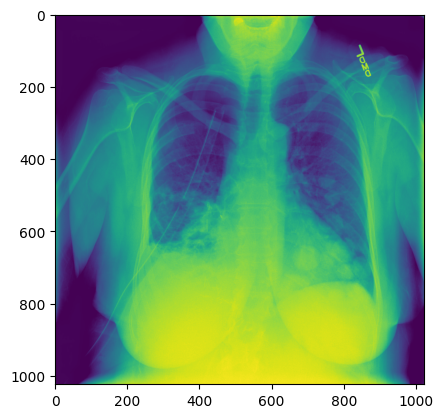

In [93]:
# Print out a sample data

import pydicom

image = pydicom.dcmread(train_images_path[0])
image_pixel = image.pixel_array
plt.imshow(image_pixel)

In [ ]:
# File path of the labels

train_labels_file = data_file/'stage_2_train_labels.csv'
train_labels_file

WindowsPath('data/pneumonia_dataset/stage_2_train_labels.csv')

## Working with label documnet of test images with is a CSV file with python built in `csv` module

In [80]:
all_labels_list = []

import csv

with open(train_labels_file,) as csvfile:
    csv_reader = csv.reader(csvfile)

    # # Skip the header row (optional)
    # next(csv_reader)

    # Calling this will also store the header of the CSV file in the `header` variable and the next time we call `csv_reader` we will have directly access to the data values
    header = next(csv_reader)
    print(header)

    label_index = header.index('Target')
    # print(label_index)

    for row in csv_reader:
        # print(row)
        # print(row[label_index])

        
        labels = int(row[label_index])
        # print(labels)
        all_labels_list.append(labels)
        # break

['patientId', 'x', 'y', 'width', 'height', 'Target']


In [ ]:
# all_images_path[-1]

image_path = all_images_path[-1]

image = pydicom.dcmread(image_path)
patientID = image.PatientID
patientID, all_images_path[-1]

('fffec09e-8a4a-48b1-b33e-ab4890ccd136',
 WindowsPath('data/pneumonia_dataset/stage_2_train_images/fffec09e-8a4a-48b1-b33e-ab4890ccd136.dcm'))

In [85]:
len(all_images_path)

29684

[0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,


In [37]:
labels_list = []

import csv

# Open the CSV file in read mode
with open(train_labels_file, newline='', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    
    # # Skip the header row (optional)
    # next(csvreader)

    header = next(csvreader)
    print(x)


    # Loop through the rows and print each row
    for row in csvreader:
        print(row)
        break
        print(row['Target'])


['patientId', 'x', 'y', 'width', 'height', 'Target']
['0004cfab-14fd-4e49-80ba-63a80b6bddd6', '', '', '', '', '0']


## Working with label document of test images which is a CSV file with `pandas`

In [23]:
import random

rand_int_list = random.sample(range(len(train_images_path)), k=18)
rand_int_list


[19973,
 24484,
 628,
 18678,
 1997,
 3761,
 10154,
 19207,
 13608,
 24490,
 14614,
 12835,
 24164,
 19772,
 534,
 987,
 25317,
 131]

In [112]:
labels_dict = {0: 'Absent',
               1: 'Present'}


In [113]:
labels_dict[0], labels_dict[1]

('Absent', 'Present')

0
0
0
1
0
1
0
1
1
0
0
0
0
0
0
0
0
1


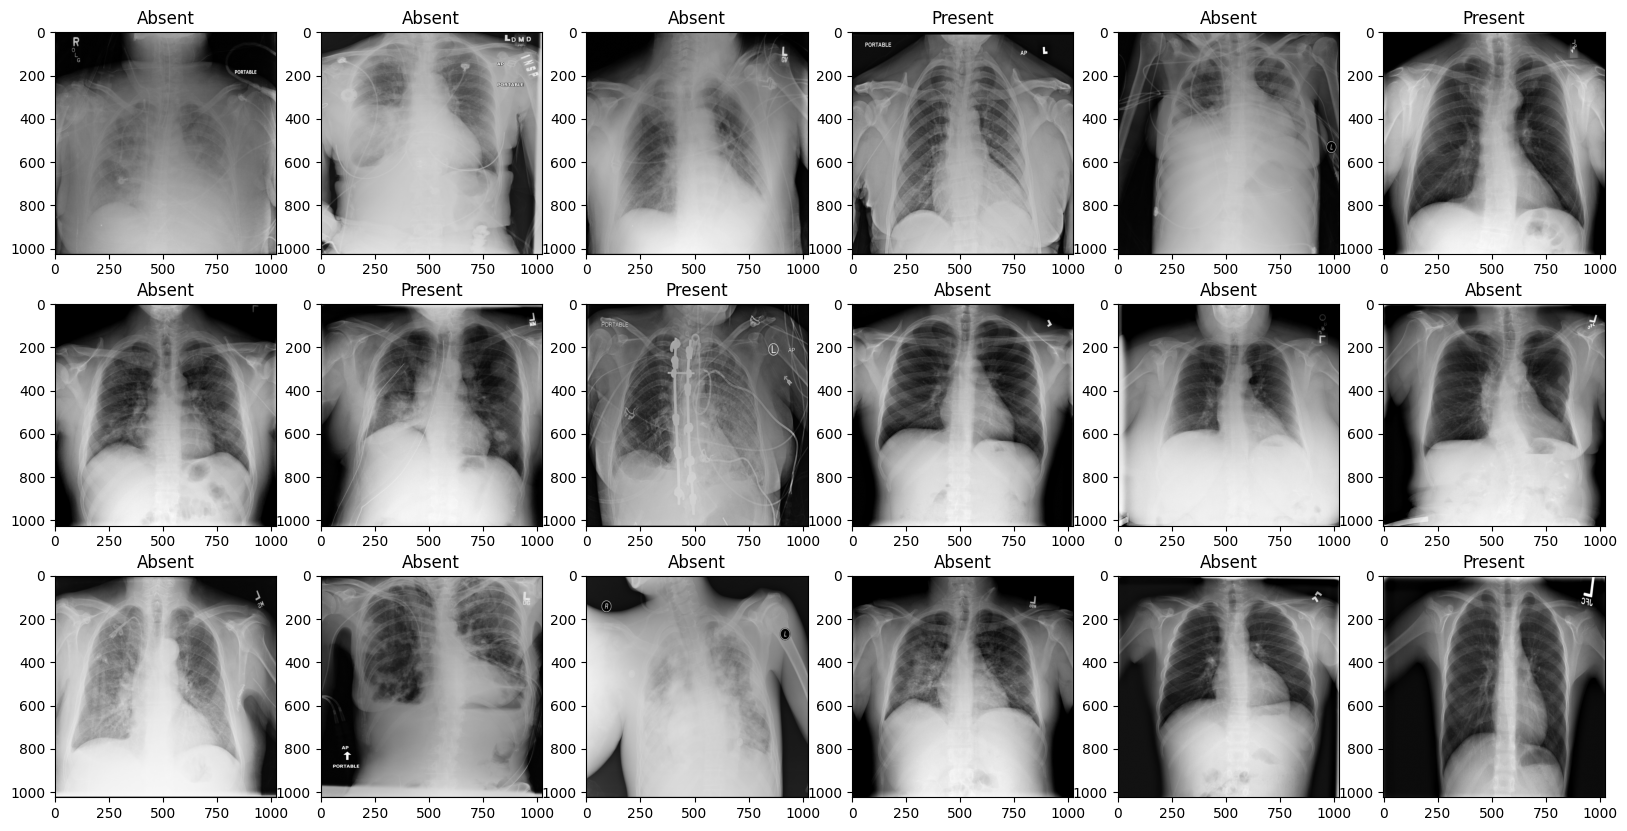

In [114]:
plt.figure(figsize=(20, 10))

for i in range(len(rand_int_list)):
    plt.subplot(3, 6, i+1)

    random_int = rand_int_list[i]
    
    image_path = train_images_path[random_int]
    image = pydicom.dcmread(image_path)
    image_pixel = image.pixel_array

    plt.imshow(image_pixel, cmap='gray')
    image_label = all_labels_list[random_int]

    print(image_label)
    plt.title(labels_dict[image_label])
 
